In [192]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow torch nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [193]:

# Load the data
data = pd.read_excel('/content/Multilingual PUBG Reviews for Sentiment Analysis.xlsx')

# Preprocess the data
def preprocess_data(data):
    """Preprocess the raw data."""
    try:
        # Convert date columns to datetime
        data['Review_Publication_Date'] = pd.to_datetime(data['Review_Publication_Date'])
        data['Review_Updated_Date'] = pd.to_datetime(data['Review_Updated_Date'])

        # Drop unnecessary columns
        data.drop(['Recommendation_ID', 'Review_Updated_Date'], axis=1, inplace=True)

        # Scale 'Playtime' column
        scaler = MinMaxScaler()
        data['Playtime'] = scaler.fit_transform(data[['Playtime']])

        # Encode categorical variables
        le_recommend_tag = LabelEncoder()
        data['Recommend_Tag'] = le_recommend_tag.fit_transform(data['Recommend_Tag'])
        le_language_tag = LabelEncoder()
        data['Language_Tag'] = le_language_tag.fit_transform(data['Language_Tag'])

        return data
    except Exception as e:
        print(f"Error preprocessing data: {e}")
        return None

data = preprocess_data(data)


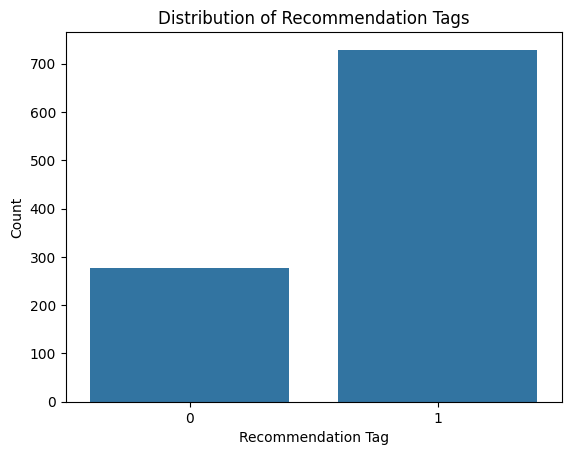

In [194]:

# Data Visualization
sns.countplot(x='Recommend_Tag', data=data).set_title('Distribution of Recommendation Tags')
plt.xlabel('Recommendation Tag')
plt.ylabel('Count')
plt.show()



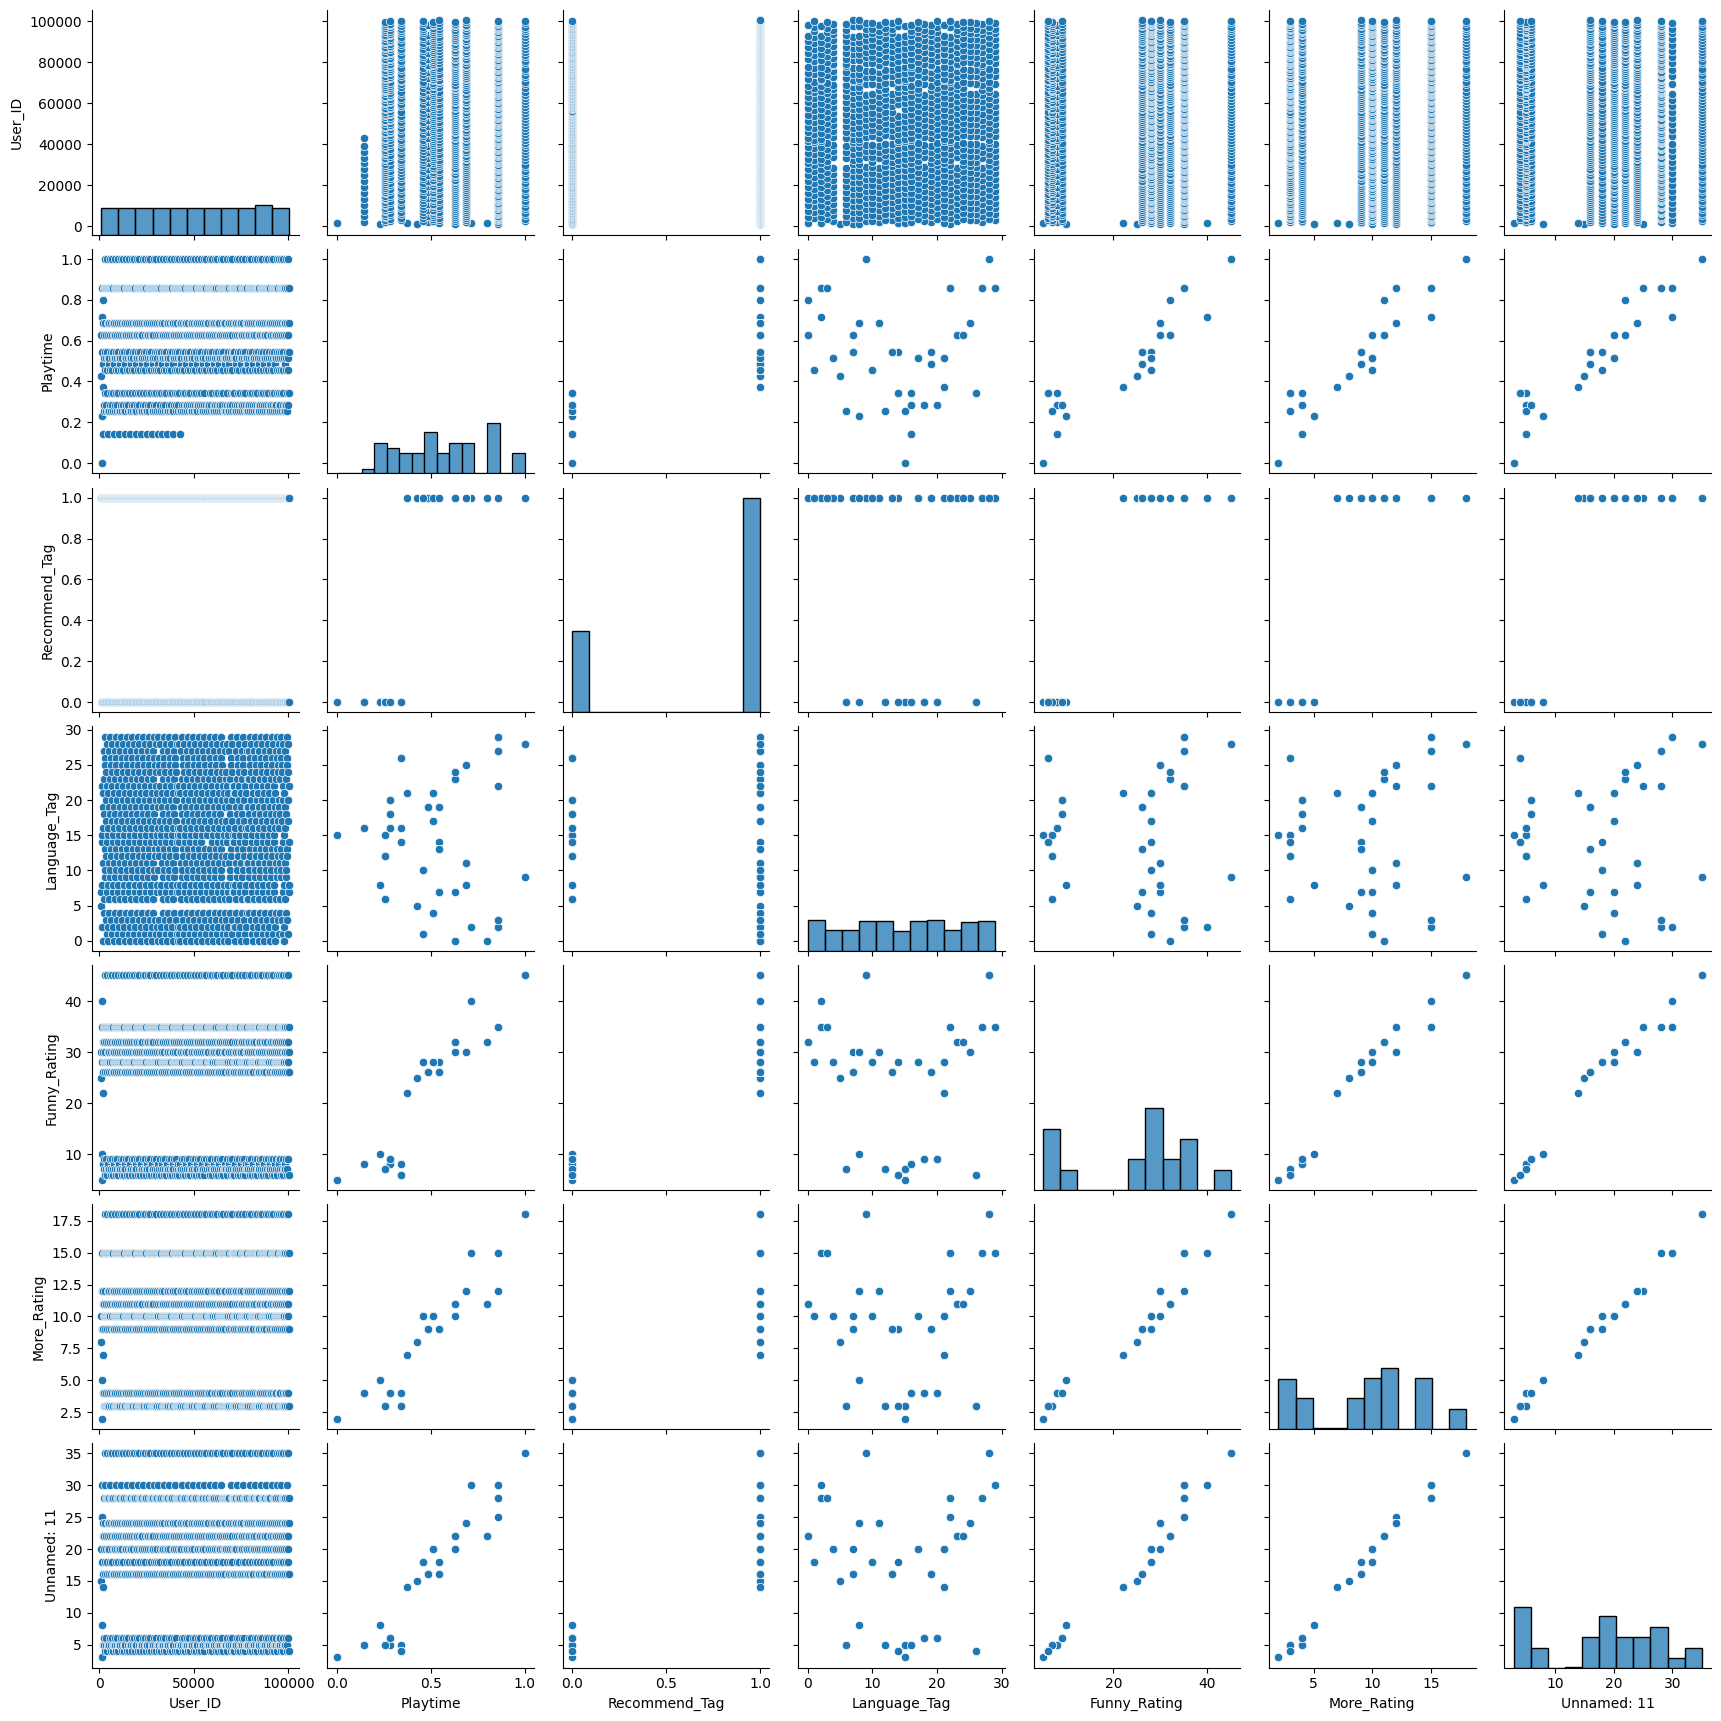

In [195]:
# Pairplot
sns.pairplot(data)
plt.show()


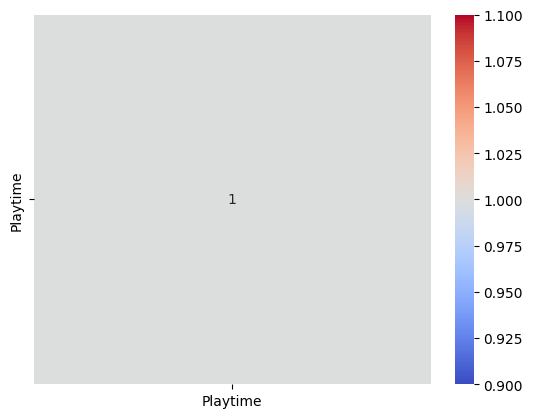

In [196]:

# Correlation Heatmap
sns.heatmap(data[['Playtime']].corr(), annot=True, cmap='coolwarm')
plt.show()


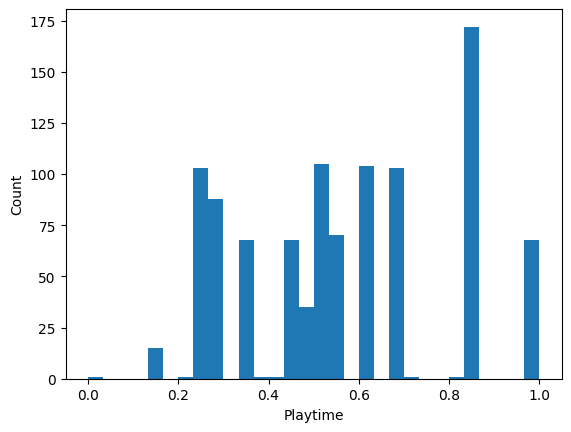

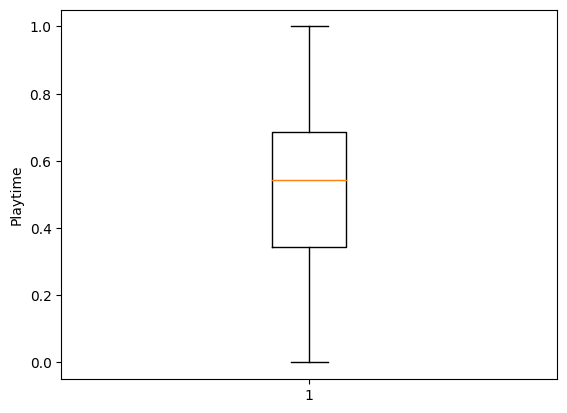

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32321 (\N{CJK UNIFIED IDEOGRAPH-7E41}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dis

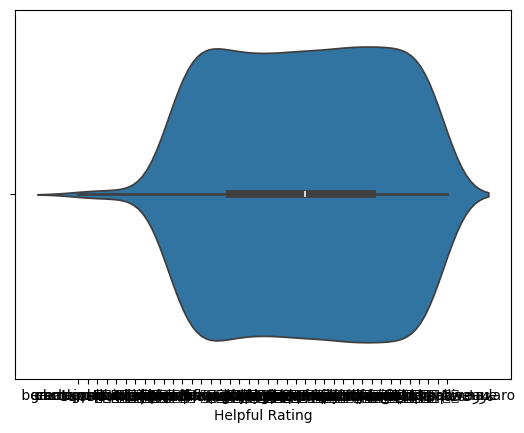

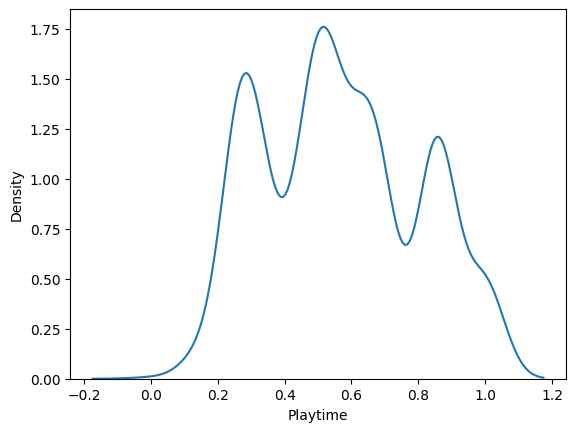

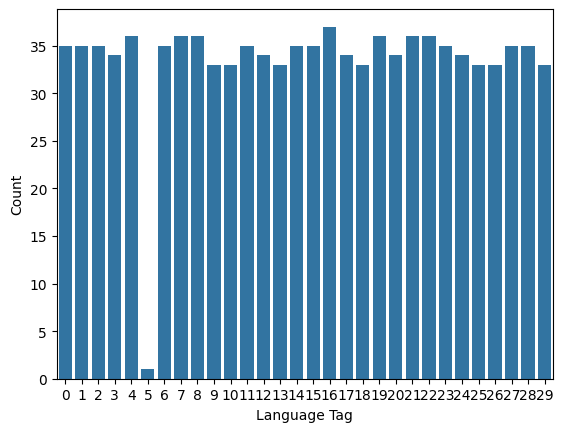

<ipython-input-197-31cefa5f23e2>:29: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


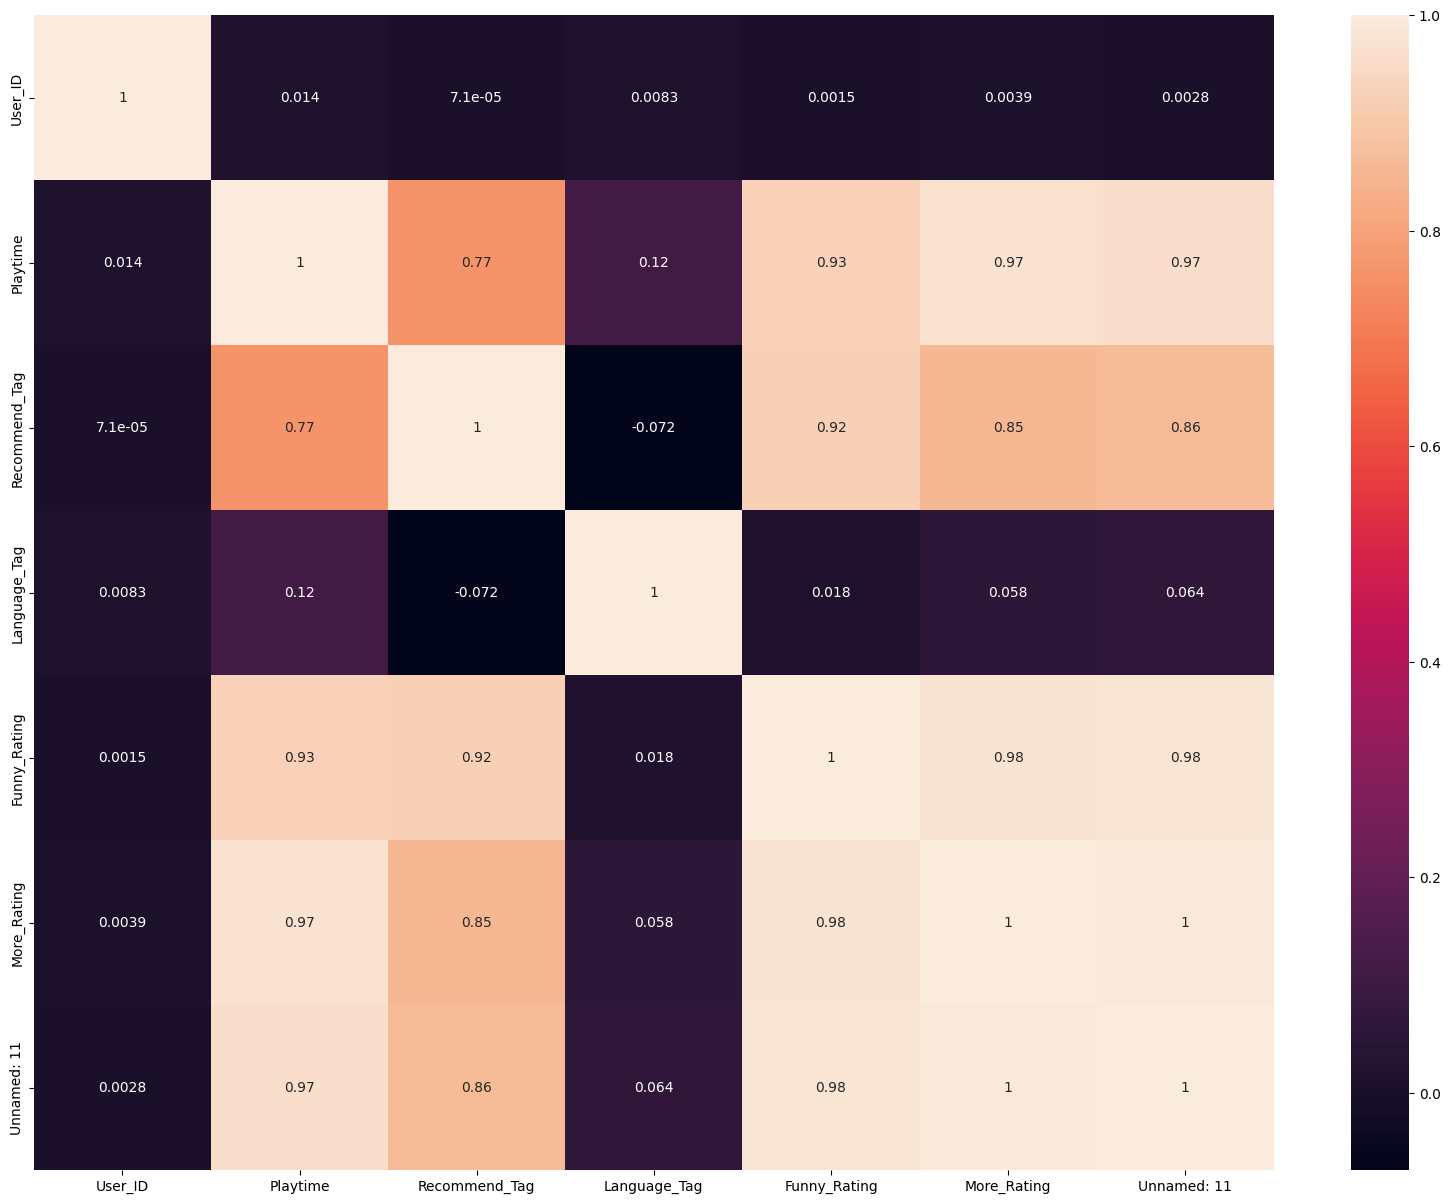

In [197]:

# Histogram of Playtime
plt.hist(data['Playtime'], bins=30)
plt.xlabel('Playtime')
plt.ylabel('Count')
plt.show()

# Boxplot of Playtime
plt.boxplot(data['Playtime'])
plt.ylabel('Playtime')
plt.show()

# Violinplot of Helpful Rating
sns.violinplot(x='Helpful_Rating', data=data)
plt.xlabel('Helpful Rating')
plt.show()

# Kernel Density Estimation Plot of Playtime
sns.kdeplot(data['Playtime'])
plt.xlabel('Playtime')
plt.show()

# Countplot of Language Tag
sns.countplot(x='Language_Tag', data=data)
plt.xlabel('Language Tag')
plt.ylabel('Count')
plt.show()

# Correlation Matrix Heatmap
corr = data.corr()
plt.subplots(figsize=(20, 15))
sns.heatmap(corr, annot=True)
plt.show()


In [198]:

# Handle missing values
def handle_missing_values(data):
    """Handle missing values."""
    try:
        print(data.isnull().any())
        print(data.isnull().sum())
        data.dropna(inplace=True)
        print(data.isnull().sum())
        return data
    except Exception as e:
        print(f"Error handling missing values: {e}")
        return None

data = handle_missing_values(data)


User_ID                    False
Review_Publication_Date    False
Playtime                   False
Recommend_Tag              False
Language_Tag               False
Review_Content             False
Helpful_Rating              True
Funny_Rating                True
More_Rating                 True
Unnamed: 11                 True
dtype: bool
User_ID                    0
Review_Publication_Date    0
Playtime                   0
Recommend_Tag              0
Language_Tag               0
Review_Content             0
Helpful_Rating             1
Funny_Rating               1
More_Rating                1
Unnamed: 11                1
dtype: int64
User_ID                    0
Review_Publication_Date    0
Playtime                   0
Recommend_Tag              0
Language_Tag               0
Review_Content             0
Helpful_Rating             0
Funny_Rating               0
More_Rating                0
Unnamed: 11                0
dtype: int64


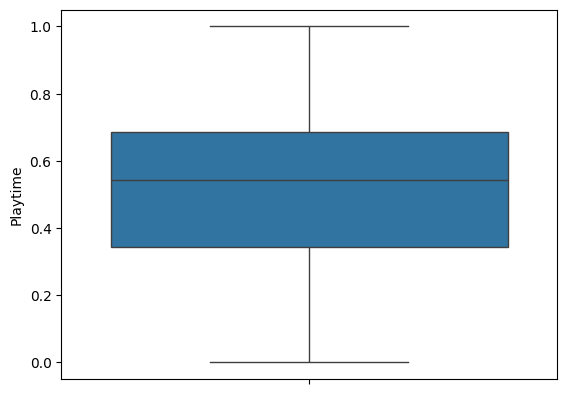

In [199]:

# Outlier detection and removal
def remove_outliers(data):
    """Remove outliers using IQR method."""
    try:
        Q1 = data['Playtime'].quantile(0.25)
        Q3 = data['Playtime'].quantile(0.75)
        IQR = Q3 - Q1
        data = data[~((data['Playtime'] < (Q1 - 1.5 * IQR)) | (data['Playtime'] > (Q3 + 1.5 * IQR)))]
        sns.boxplot(data['Playtime'])
        plt.ylabel('Playtime')
        plt.show()
        return data
    except Exception as e:
        print(f"Error removing outliers: {e}")
        return None

data = remove_outliers(data)


In [200]:

# Select features and target variable
def select_features(data):
    """Select features and target variable."""
    try:
        target = data['Helpful_Rating']
        features = data.drop(['User_ID', 'Review_Publication_Date', 'Playtime','Recommend_Tag','Funny_Rating','More_Rating','Unnamed: 11','Language_Tag'], axis=1)
        return features, target
    except Exception as e:
        print(f"Error selecting features: {e}")
        return None, None

features, target = select_features(data)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32321 (\N{CJK UNIFIED IDEOGRAPH-7E41}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dis

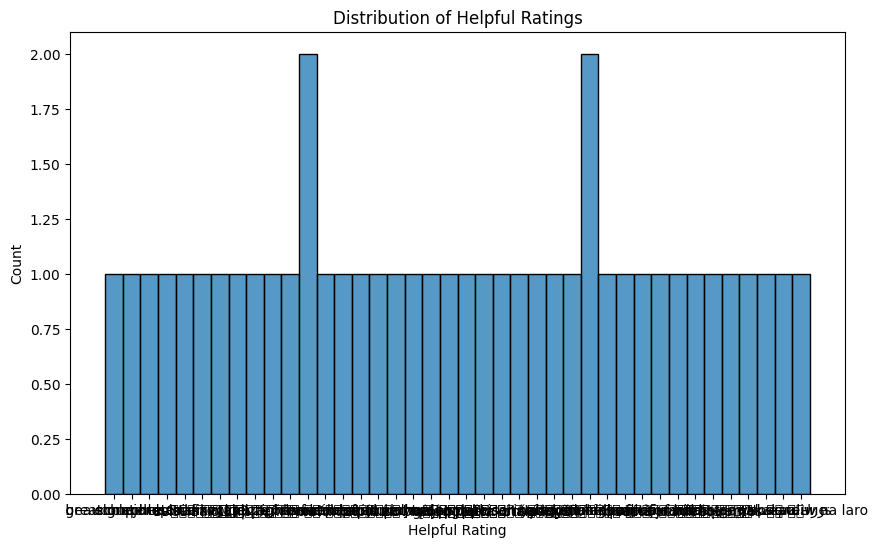

In [201]:

# Text preprocessing
def preprocess_text(text):
    """Preprocess text data."""
    try:
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word.isalpha()]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return None

def preprocess_text_data(data):
    """Preprocess text data and visualize the distribution of helpful ratings."""
    try:
        df_text = data[['Review_Content', 'Helpful_Rating']].dropna().drop_duplicates()
        df_text['Review_Content'] = df_text['Review_Content'].apply(preprocess_text)

        # Data Visualization
        plt.figure(figsize=(10, 6))
        sns.histplot(df_text['Helpful_Rating'])
        plt.title('Distribution of Helpful Ratings')
        plt.xlabel('Helpful Rating')
        plt.ylabel('Count')
        plt.show()

        return df_text
    except Exception as e:
        print(f"Error preprocessing text data: {e}")
        return None

df_text = preprocess_text_data(data)


In [202]:

# Splitting the data
def split_data(features, target):
    """Split the data into training and testing sets."""
    try:
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Error splitting the data: {e}")
        return None, None, None, None

X_train, X_test, y_train, y_test = split_data(features, target)


In [203]:

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

print(features.columns)




Index(['Review_Content', 'Helpful_Rating'], dtype='object')


In [204]:
# Text vectorization
def vectorize_text(X_train, X_test):
    """Vectorize text data."""
    try:
        vectorizer = TfidfVectorizer()
        X_train_vectorized = vectorizer.fit_transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)
        return X_train_vectorized, X_test_vectorized
    except Exception as e:
        print(f"Error vectorizing text: {e}")
        return None, None

X_train_vectorized, X_test_vectorized = vectorize_text(X_train['Review_Content'], X_test['Review_Content'])



In [219]:
# Hyperparameters
input_size_text = X_train_vectorized.shape[1]  # Size of input features
hidden_size_text = 128  # Number of features in the hidden state of LSTM
num_layers_text = 2  # Number of LSTM layers
output_size_text = 1  # Size of the output (helpful rating)

# Initialize the model
model_text = LSTMModel(input_size_text, hidden_size_text, num_layers_text, output_size_text)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_text.to(device)

# Define loss function and optimizer
criterion_text = nn.MSELoss()
optimizer_text = optim.Adam(model_text.parameters(), lr=0.001)

# Convert labels to numerical labels
le = LabelEncoder()
y_train_numerical = le.fit_transform(y_train)
y_test_numerical = le.transform(y_test)

# Convert the numerical labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train_numerical, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_numerical, dtype=torch.float32).to(device)

# Convert data to tensor and move to device
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32).to(device)

# Define DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_text.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_text.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Ensure input tensor has correct shape
        inputs = inputs.unsqueeze(1)  # Add a dimension for sequence length (sequence length = 1 in your case)

        outputs = model_text(inputs)
        loss = criterion_text(outputs.squeeze(), labels)
        loss.backward()
        optimizer_text.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Evaluation
model_text.eval()
with torch.no_grad():
    # Forward pass on test data
    outputs = model_text(X_test_tensor.unsqueeze(1))
    predictions = (outputs.squeeze().cpu().numpy() >= 0.5).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test_numerical, predictions))


    # Calculate additional metrics
    test_accuracy = accuracy_score(y_test_numerical, predictions)
    test_precision = precision_score(y_test_numerical, predictions, average='macro')
    test_recall = recall_score(y_test_numerical, predictions, average='macro')
    test_f1 = f1_score(y_test_numerical, predictions, average='macro')

    # Print evaluation metrics
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')

# Save the trained model
torch.save(model_text.state_dict(), 'lstm_sentiment_analysis_model.pth')


Epoch [1/10], Loss: 496.3098
Epoch [2/10], Loss: 453.7006
Epoch [3/10], Loss: 321.5790
Epoch [4/10], Loss: 182.3244
Epoch [5/10], Loss: 114.6486
Epoch [6/10], Loss: 89.5661
Epoch [7/10], Loss: 70.7254
Epoch [8/10], Loss: 55.6329
Epoch [9/10], Loss: 44.2102
Epoch [10/10], Loss: 34.5994
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.04      1.00      0.07         7
           3       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif